## 11 – Deep Learning

在第10章中，我们介绍了人工神经网络并训练我们的第一个深度神经网络。但它是一个非常浅的DNN，只有两个隐藏层。如果你需要解决一个非常复杂的问题，例如在高分辨率图像中检测数百种类型的对象，该怎么办？你可能需要训练更深入的DNN，可能有（比方说）10层，每层包含数百个神经元，由数十万个连接连接。这不是在公园散步：


* 首先，你将面临棘手的梯度消失问题（或者相关的爆炸梯度问题）， 这会影响深层神经网络并使下层很难训练。

* 其次，如此庞大的网络，训练将非常缓慢。

* 第三，具有数百万个参数的模型将严重地过度拟合训练集。

在本章中，我们将依次讨论这些问题并提出技术解决它们。

* 我们将首先解释梯度消失问题，并探索一些最常用的解决方案。

* 接下来我们将看看各种优化器，与普通的Gradient Descent相比，它可以极大地加速训练大型模型。

* 最后，我们将介绍一些用于大型神经网络的流行正则化技术。

使用这些工具，你将能够训练非常深的网络：欢迎来到深度学习！

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [12]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
CHAPTER_ID = "11_Training Deep Neural Nets"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 1. Vanishing/Exploding Gradients Problem

正如我们在第10章中讨论过的，反向传播算法的工作原理是从输出层到输入层，在路上传播误差梯度。一旦算法计算了关于网络中每个参数的成本函数的梯度，它就使用这些梯度通过梯度下降步骤更新每个参数。


不幸的是，随着算法进展到较低层，梯度通常会变得越来越小。因此，Gradient Descent更新使得较低层连接权重几乎不变，并且训练永远不会收敛到一个好的解决方案。这被称为**梯度消失**问题。在某些情况下，可能会发生相反的情况：梯度可能会变得越来越大，因此很多层都会获得非常大的权重更新，并且算法会发生变化。这是**梯度爆炸**问题，主要在递归神经网络中遇到（见第14章）。更一般地说，深度神经网络受到不稳定梯度的影响;不同的层可以以不同的速度学习。

虽然这种不幸的行为已经在实践中被发现很长一段时间（这就是为什么深度神经网络大多被放弃很久的原因之一），直到2010年左右，在理解它方面才取得了重大进展。一篇由Xavier Glorot和Yoshua Bengio发表的题为“Understanding the Difficulty of Training Deep Feedforward Neural Networks” 的文章发现了一些东西，包括流行的logistic sigmoid激活函数和当时最受欢迎的权重初始化技术，即：使用平均值为0且标准差为1的正态分布进行随机初始化。

简而言之，他们表明，**利用这种激活函数和这种初始化方案，每层输出的方差远大于其输入的方差**。在网络中向前推进，方差在每层之后不断增加，直到激活函数在顶层饱和。事实上，逻辑函数的平均值为0.5，而不是0，这实际上变得更糟（双曲正切函数的平均值为0，并且表现略好于深度网络中的逻辑函数）。

查看逻辑激活函数（见图11-1，即下图），你可以看到当输入变大（负或正）时，函数在0或1饱和，导数非常接近0。因此，当反向传播开始时，它实际上没有梯度传播回网络，并且当反向传播通过顶层向下传播时，存在的小梯度不断被稀释，因此实际上没有任何东西留给下层。

In [13]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


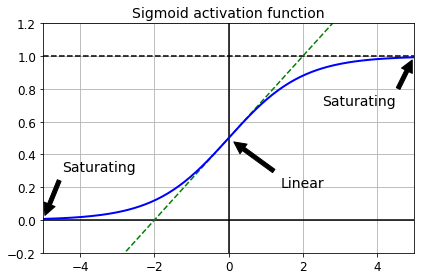

In [14]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## 1.1 Xavier and He Initialization

在他们的论文中，Glorot和Bengio提出了一种显着缓解这一问题的方法。我们需要信号在两个方向上正确流动：

**在进行预测时向前方向，在向后传播梯度时向反方向流动**。

我们不希望信号消失，我们也不希望它爆炸和饱和。为了使信号正常流动，作者认为我们需要**每层输出的方差等于其输入的方差**，并且我们还需要梯度在反向传播时。在一层神经网络之前和之后具有相等的方差（如果你对数学细节感兴趣，请查看论文）。

除非该层具有相同数量的输入和输出连接，否则实际上不可能保证两者，但是他们提出了一个良好的折衷方案，已经证明在实践中非常有效：**连接权重必须如公式11- 1所述随机初始化 ，其中 n 个输入和 n 个输出是正在初始化权重的层的输入和输出连接数（也称为扇入和扇出）。

这种初始化策略通常称为**Xavier初始化**（在作者的名字之后），或者有时称为**Glorot初始化**。

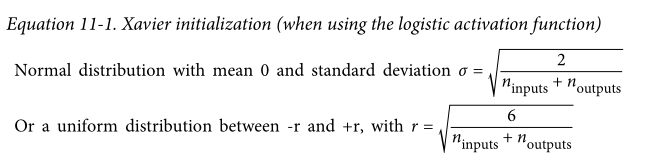

当输入连接数大致等于输出连接的数量，你得到更简单的方程
（例如，$σ = 1 / \sqrt[n]{n_{inputs}}$  或 $r =\sqrt[2]{3}  /  \sqrt[n]{n_{inputs}}$）。

我们在第10章中使用了这种简化策略,使用Xavier初始化策略可以大大加快训练速度，这是导致目前深度学习成功的技巧之一。最近的一些论文为不同的激活函数提供了类似的策略，如表11-1所示。ReLU激活函数的初始化策略（及其变体，包括稍后描述的ELU激活）有时称为**He初始化**（在其作者的姓氏之后）

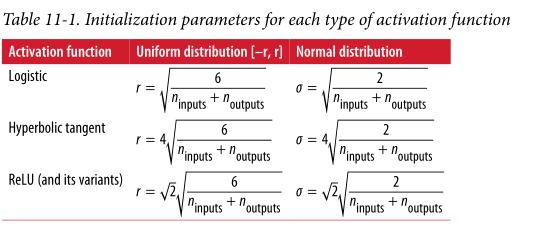

默认情况下，fully_connected（）函数（在第10章中介绍）使用Xavier初始化（具有均匀分布）。

你可以使用**variance_scaling_initializer（）函数**将此更改为He初始化，如下所示：

注意：这本书使用`tensorflow.contrib.layers.fully_connected（）`而不是`tf.layers.dense（）`（在编写本章时不存在）。现在最好使用`tf.layers.dense（）`，因为contrib模块中的任何内容都可能更改或删除，恕不另行通知。

`dense（）`函数几乎与`fully_connected（）`函数相同。与本章相关的主要差异是：

* 几个参数被重命名：`scope`变为`name`，`activation_fn`变为`activation`（ 类似地，`_fn` 后缀从其他参数中删除，例如`normalizer_fn`），`weights_initializer`变为`kernel_initializer`等。
 
*  默认的`activation`现在是`None`而不是`tf.nn.relu`。

* 它不支持`tensorflow.contrib.framework.arg_scope（）`（稍后在第11章介绍）。

* 它不支持正则化参数（稍后在第11章介绍）。

In [15]:
import tensorflow as tf

In [16]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [17]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

He 初始化只考虑扇入，而不是像Xavier初始化那样扇入和扇出之间的平均值。
这也是**variance_scaling_initializer（）函数**的默认值，但你可以通过设置参数mode =“FAN_AVG”来更改此值。

## 1.2 Nonsaturating Activation Functions

Glorot和Bengio在2010年论文中的见解之一是消失/爆炸梯度问题部分是由于激活函数选择不当。直到那时大多数人都认为，如果大自然母亲选择在生物神经元中使用大致的sigmoid activation functions，它们必定是一个很好的选择。但事实证明，其他激活函数在深度神经网络中表现得更好，尤其是ReLU激活函数，主要是因为它不会为正值饱和（并且还因为计算速度非常快）。


不幸的是，ReLU激活函数并不完美。它遇到了一个被称为垂死的ReLUs的问题：

*  在训练过程中，一些神经元会有效死亡，这意味着它们会停止输出0以外的任何东西。
*  在某些情况下，你可能会发现网络神经元的一半已经死亡，特别是如果你使用了很高的学习率。
* 在训练期间，如果神经元的权重得到更新，使得神经元输入的加权和为负，则它将开始输出0.当发生这种情况时，由于ReLU函数的梯度为0，神经元不太可能恢复生命。它的输入是否定的。

要解决这个问题，你可能想要使用ReLU功能的变体，例如**Leaky ReLU**。该函数定义为$ Leaky ReLU_α(z)= max(αz，z)$（见图11-2即下图）。

超参数 $α$ 定义函数“Leaky”的程度：它是 $ z < 0 $  时函数的斜率，通常设置为0.01。这个小斜坡确保Leaky ReLU永不死亡;他们可以长时间昏迷，但他们有机会最终醒来。最近的一篇论文比较了ReLU激活函数的几种变体，其结论之一是**Leaky 变体总是优于严格的ReLU激活函数**。

实际上，设定$α= 0.2（巨大泄漏）$似乎导致比$α= 0.01（小泄漏）$更好的性能。他们还评估了 随机泄漏ReLU（RReLU），即在**训练期间**在给定范围内随机选取$α$，并且在**测试期间**将其固定为平均值。它也表现得相当好，似乎充当了正则化的角色（降低了过度拟合训练集的风险）。

最后，他们还评估了参数泄漏ReLU（PReLU），其中$α$被授权在训练期间被学习（而不是超参数，它变成可以像任何其他参数一样通过反向传播来修改的参数）。据报道，这在大型图像数据集上的表现强于ReLU，但在较小的数据集上，它存在过度拟合训练集的风险。

### Leaky ReLU

In [18]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


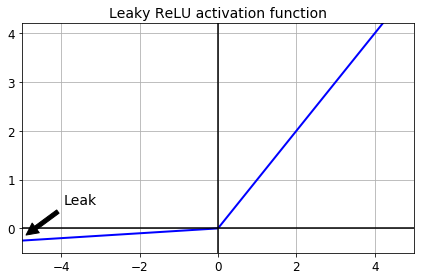

In [19]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

在TensorFlow中实现 **Leaky ReLU**：

In [20]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [21]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

让我们使用Leaky ReLU在MNIST上训练神经网络。 首先让我们创建图表：

In [22]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [23]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [24]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [25]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [26]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [27]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [28]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

下载数据：

警告：不推荐使用tf.examples.tutorials.mnist。 我们将改用**tf.keras.datasets.mnist**。

In [29]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [30]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [31]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9048
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
15 Batch accuracy: 0.94 Validation accuracy: 0.9712
20 Batch accuracy: 1.0 Validation accuracy: 0.9764
25 Batch accuracy: 1.0 Validation accuracy: 0.9774
30 Batch accuracy: 0.98 Validation accuracy: 0.9782
35 Batch accuracy: 1.0 Validation accuracy: 0.9786


### ELU

2015年由Djork-ArnéClevert等人撰写的论文。 提出了一种称为**指数线性单位 -  exponential linear unit（ELU）**的新激活函数，其在实验中的表现优于所有ReLU变体：训练时间减少，神经网络在测试集上表现更好。

它如图11-3所示即下图，公式11-2显示了它的定义。

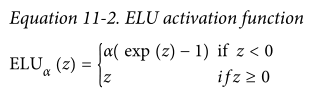

In [32]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


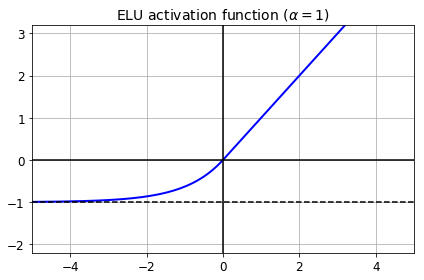

In [33]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

它看起来很像ReLU功能，但有一些主要区别：

* 首先，当z <0时，它采用负值，这允许该单位的平均输出接近0。如前所述，这**有助于缓解消失的梯度问题**。超参数 $ α$定义当 $z$ 是大负数时ELU函数接近的值。 它通常设置为1，但如果你愿意，可以像任何其他超参数一样调整它。

* 其次，它对于 $z <0 $具有非零梯度，这避免了死亡单位的问题。

* 第三，函数在任何地方都是平滑的，包括z = 0左右，这有助于加速梯度下降，因为它不会在z = 0的左右反弹。

**ELU激活功能的主要缺点**是它的计算速度比ReLU及其变量慢（由于使用了指数函数），但在训练期间，这可以通过更快的收敛速度得到补偿。但是，在测试时，ELU网络将比ReLU网络慢。

**那么你应该将哪个激活函数用于深层神经网络的隐藏层？** 虽然你的里程会有所不同，但是一般：

**ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic**。

* 如果你非常关心运行时性能，那么你可能更喜欢leaky ReLU 而不是ELU。
* 如果不想调整另一个超参数，可以使用之前建议的默认$α$值（leaky ReLU为0.01，ELU为1）。
* 如果你有空余时间和计算能力，你可以使用交叉验证来评估其他激活功能，特别是如果你的网络过度拟合则使用 RReLU，或者如果你拥有庞大的训练集，则使用PReLU。

在TensorFlow中实现ELU比较简单，只需在构建每个层时指定激活函数：

In [34]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

TensorFlow提供了一个elu（）函数，可用于构建神经网络。只需要调用**tf.layers.dense（）函数**时设置**activation**参数即可，如下所示：

In [35]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

TensorFlow没有针对**leaky ReLU**的预定义函数，但很容易定义：

In [36]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)
hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu)

### SELU

这个激活函数是由GünterKlambauer，Thomas Unterthiner和Andreas Mayr在2017年6月出版的这篇伟大论文中提出的（我肯定会将其添加到本书中）。

在训练期间，由使用**SELU激活函数**的一堆密集层组成的神经网络将**自我归一化**：**每层的输出将倾向于在训练期间保持相同的均值和方差，这解决了消失/爆炸的梯度问题**。 因此，这种激活函数对于这样的神经网络而言非常显着地优于其他激活函数，因此你应该尝试一下。

In [37]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


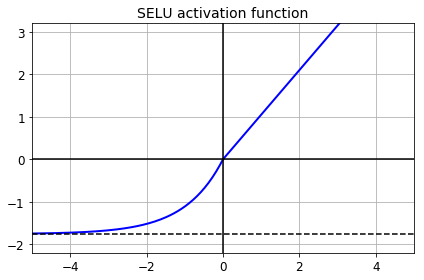

In [38]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

默认情况下，**调整SELU超参数（scale和α），使平均值保持接近0，标准差保持接近1（假设输入标准化为均值0和标准差1）。使用此激活函数，即使是100层深度神经网络，也可以在所有层上保留大致平均值0和标准偏差1，从而避免爆炸/消失梯度问题**：

In [39]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


在TensorFlow 1.4中添加了tf.nn.selu（）函数。 对于早期版本，你可以使用以下实现：

In [40]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

然而，**SELU激活函数不能与常规Dropout一起使用（这会取消SELU激活功能的自我规范化属性）**。幸运的是，在同一篇论文中提出了一种名为**Alpha Dropout**的Dropout变体。在TF 1.4及以后的版本中，它可以在tf.contrib.nn.alpha_dropout（）中获得，（或者查看生物信息学研究所，Johannes Kepler University Linz的[实现](https://github.com/bioinf-jku/SNNs/blob/master/selu.py)）。

让我们使用SELU激活函数为MNIST创建一个神经网络：

In [41]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

现在让我们训练吧。 **不要忘记将输入缩放到均值为0和标准差1**：

In [42]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9232
5 Batch accuracy: 0.98 Validation accuracy: 0.9574
10 Batch accuracy: 1.0 Validation accuracy: 0.9664
15 Batch accuracy: 0.96 Validation accuracy: 0.9684
20 Batch accuracy: 1.0 Validation accuracy: 0.9692
25 Batch accuracy: 1.0 Validation accuracy: 0.9692
30 Batch accuracy: 1.0 Validation accuracy: 0.9692
35 Batch accuracy: 1.0 Validation accuracy: 0.9698


## 1.3 Batch Normalization

尽管使用He初始化以及ELU（或ReLU的任何变体）可以显着减少训练开始时消失/爆炸的梯度问题，但并不能保证他们在训练期间不会回来。

在2015年的一篇论文中，Sergey Ioffe和Christian Szegedy提出了一种称为**批量标准化（BN）**的技术来解决消失/爆炸的梯度问题，更一般地说，随着前一层的参数变化，每个层的输入分布在训练期间发生变化的问题（他们称之为**内部协变量转换**问题）。

该技术包括**在每个层的激活函数之前在模型中添加操作，只需将零中心和标准化输入，然后使用每层两个新参数缩放和移动结果**（一个用于缩放，另一个用于移位）。换句话说，此操作可**让模型了解每层输入的最佳比例和平均值**。

**为了使输入为零中心和标准化，算法需要估计输入的均值和标准差**。它是通过评估当前小批量输入的平均值和标准差来实现的（因此称为“批量标准化”）。

整个操作总结在公式11-3中。

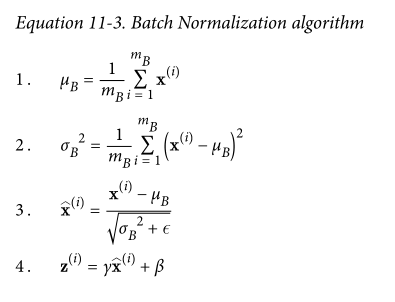

* $ μ_B$ 是经验均值，在整个小批量B上进行评估。
* $ σ_B$ 是经验标准偏差，也在整个小批量上进行评估。
* $ m_B$ 是小批量中的实例数。
* $ \hat {x}^{(i)}$ 是零中心和标准化的输入。
* $ γ$ 是网络层的缩放参数。
* $ β$ 是网络层的移位参数（偏移）。
* $ ε$ 是一个微小的数字，以避免被零除（通常为10 -3）。这称为**平滑项**。
* $  z(i)$ 是BN操作的输出：它是输入的缩放和移位版本。

在测试时，没有小批量来计算经验均值和标准差，所以你只需要使用整个训练集的均值和标准差。这些通常在训练期间使用移动平均值有效地计算。因此，总共为每个批量标准化层学习了四个参数：$γ（缩放），β（偏移），μ（平均值）和σ（标准偏差）$。

作者证明了这项技术大大改善了他们实验过的所有深度神经网络。
* 梯度消失的问题大大减少了，他们可以使用饱和激活函数，例如tanh甚至逻辑激活函数。

* 网络对权重初始化也不太敏感。他们能够使用更高的学习率，显着加快学习过程。

   * 具体来说，他们注意到“应用于最先进的图像分类模型，批量标准化实现了相同的准确度，训练步骤减少了14倍，并且大大超过了原始模型。 [...]使用批量标准化网络的集合，我们改进了ImageNet分类的最佳公布结果：达到4.9％的前5名验证错误（以及4.8％的测试错误），超出了人类评估者的准确性。”

* 最后，就像一个不断给予的礼物，批量标准化也像正则化器一样，减少了对其他正则化技术的需求（例如本章后面描述的dropout）。

但是，
* 批量标准化确实会给模型增加一些复杂性（虽然它不需要对输入数据进行标准化，因为第一个隐藏层会处理它，提供给它的是批量标准化的）。

* 此外，还有一个运行时间的惩罚：由于每层需要额外的计算，神经网络的预测速度较慢。

因此，**如果你需要快速预测，你可能需要在使用批量标准化之前检查普通 ELU + He 初始化的执行情况**。

你可能会发现训练起初相当慢，当梯度下降正在寻找每一层的最佳尺度和偏移时，但是一旦它找到了相当好的值，它就会加速。

### 1.3.1 Implementing Batch Normalization with TensorFlow

TensorFlow提供了一个**batch_normalization（）函数**，它只是居中和规范化输入，但你必须自己计算平均值和标准差
（基于训练期间的小批量数据或测试期间的完整数据集，如上所述）并将它们作为参数传递给此函数，你还必须处理缩放和偏移参数的创建（并将它们传递给此 函数）。

这个函数是可行的，但不是最方便的方法。 **相反，你应该使用batch_norm（）函数**，它可以为你处理所有这些。你可以直接调用它或告诉fully_connected（）函数使用它，例如在以下代码中：

注意：本书使用tensorflow.contrib.layers.batch_norm（）而不是tf.layers.batch_normalization（）（在编写本章时不存在）。**现在最好使用tf.layers.batch_normalization（）**，因为contrib模块中的任何内容都可能更改或删除，恕不另行通知。

**我们现在使用batch_normalization（）**并显式创建一个不同的层，而不是使用batch_norm（）函数作为fully_connected（）函数的正则化参数。参数有点不同，特别是：

* ```decay```重新命名为```momentum```，

* ```is_training```被重命名为```training```，

* ``updates_collections``被删除：批量标准化所需的更新操作被添加到```UPDATE_OPS```集合中，你需要在训练期间明确地运行这些操作（请**参阅下面的执行阶段**），

* 我们不需要指定`scale = True`，因为这是默认值。




另请注意，**为了在每个隐藏层的激活函数之前运行批量标准化，我们在批量标准化层之后手动应用 ELU 激活函数**。

注意：由于`tf.layers.dense（）`函数与`tf.contrib.layers.arg_scope（）`（本书中使用的）不兼容，我们现在使用python的`functools.partial（）`函数。它可以很容易地创建一个`my_dense_layer（）`函数，该函数只调用自动设置所需参数的`tf.layers.dense（）`（除非在调用`my_dense_layer（）`时覆盖它们）。如你所见，代码仍然非常相似。

In [43]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [44]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

为了避免一遍又一遍地重复相同的参数，我们可以使用Python的partial（）函数：

In [45]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

让我们为MNIST构建一个神经网络，使用ELU激活函数和每层的批量标准化：

In [46]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

注意：因为我们使用tf.layers.batch_normalization（）而不是tf.contrib.layers.batch_norm（）（如书中所示），
所以我们需要显式运行批量规范化所需的额外更新操作（sess.run（[training_op，extra_update_ops]，...）。

In [47]:
n_epochs = 20
batch_size = 200

In [48]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9018
1 Validation accuracy: 0.9268
2 Validation accuracy: 0.939
3 Validation accuracy: 0.9462
4 Validation accuracy: 0.9502
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9608
7 Validation accuracy: 0.9628
8 Validation accuracy: 0.9654
9 Validation accuracy: 0.9678
10 Validation accuracy: 0.9686
11 Validation accuracy: 0.969
12 Validation accuracy: 0.9678
13 Validation accuracy: 0.971
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9736
17 Validation accuracy: 0.9732
18 Validation accuracy: 0.9742
19 Validation accuracy: 0.9756


对于MNIST来说，这不是一个很好的准确性。 当然，**如果你训练的时间更长，它会获得更好的准确性**，但是如此浅的网络，
Batch Norm和ELU不太可能产生非常积极的影响：**它们主要用于更深层次的网络**。

请注意，您还可以使训练操作取决于更新操作：

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

这样，你只需要在训练期间评估`training_op`，TensorFlow也会自动运行更新操作：

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

还有一件事：**请注意，可训练变量列表短于所有全局变量列表。 这是因为移动平均线是不可训练的变量。
如果你想重用预训练神经网络（见下文），你一定不要忘记这些不可训练的变量**。

In [49]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [50]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## 1.4 Gradient Clipping

减少梯度爆炸问题的另一项流行技术是在反向传播过程中简单地剪辑梯度，使它们永远不会超过某个阈值（这对于递归神经网络非常有用;参见第14章）。这称为**梯度剪辑**。 一般来说，人们现在更喜欢批量标准化，但了解Gradient Clipping以及如何实现它仍然很有用。

让我们为MNIST创建一个简单的神经网络并添加渐变裁剪。 第一部分与之前相同（除了我们添加了一些层数**来演示重用预训练模型**，见下文）：

In [51]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [52]:
learning_rate = 0.01

现在我们应用梯度剪辑。为此，我们需要获取梯度，使用`clip_by_value（）`函数剪切它们，然后应用它们：

在TensorFlow中，优化器的**minimize（）函数负责计算梯度并应用它们**，因此你必须
* 先调用优化器的compute_gradients（）方法，
* 然后使用clip_by_value（）函数创建梯度剪辑的操作，
* 最后创建一个操作 使用优化程序的apply_gradients（）方法应用梯度剪辑：

In [53]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [54]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [55]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [56]:
n_epochs = 20
batch_size = 200

然后，你将像往常一样在每个训练步骤中运行此training_op。它将计算梯度，将它们剪切在-1.0和1.0之间，然后应用它们。 **阈值是你可以调整的超参数**。

In [57]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.794
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.9058
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9222
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9538
14 Validation accuracy: 0.9568
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9586
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9616


# 2. Reusing Pretrained Layers

从头开始训练一个非常大的DNN通常不是一个好主意：相反，你应该总是试图找到一个现有的神经网络，完成与你想要解决的任务类似的任务，然后只重用这个网络的较低层：这称为**迁移学习**。它不仅会大大加快训练速度，而且还需要更少的训练数据。

例如，假设你可以访问经过训练的DNN，将图片分类为100个不同的类别，包括动物，植物，车辆和日常物品。你现在想要训练DNN以对特定类型的车辆进行分类。这些任务非常相似，因此你应该尝试重用第一个网络的一部分（请参阅图11-4）。
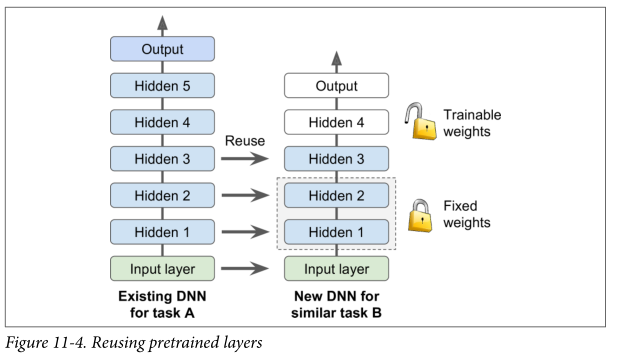

**如果新任务的输入图片与原始任务中使用的图片大小不同，则必须添加预处理步骤以将其大小调整为原始模型所需的大小**。 更一般地说，**如果输入具有类似的低级特征，则迁移学习将很有效**。

## 2.1 Reusing a TensorFlow Model

如果使用TensorFlow训练原始模型，你可以简单地恢复它并在新任务上训练它：

**首先，你需要加载图形的结构**。

**import_meta_graph（）函数**就是这样，将图形的操作加载到默认图形中，然后返回一个**Saver**，然后可以使用该Saver恢复模型的状态。请注意，默认情况下，Saver会将图形结构保存到.meta文件中，因此你应该加载该文件：

In [58]:
reset_graph()

In [59]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

**接下来，你需要处理训练所需的所有操作**。如果你不知道图形的结构，可以**列出所有操作**：

In [60]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

糟糕，这是很多操作！使用TensorBoard可视化图形要容易得多。**以下hack将允许您在Jupyter中可视化图形**
（如果它不能与你的浏览器一起使用，则需要使用FileWriter保存图形，然后在TensorBoard中将其可视化）：

In [61]:
from tensorflow_graph_in_jupyter import show_graph

In [62]:
show_graph(tf.get_default_graph())

一旦知道了所需的操作，就可以使用图形的**get_operation_by_name（）**或**get_tensor_by_name（）**方法来处理它们：

In [63]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

如果你是原始模型的作者，那么**通过为操作提供非常清晰的名称并记录它们，你可以使重新使用模型的人更容易**。 

* 另一种方法是创建一个包含人们想要处理的所有重要操作的集合：

In [64]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

这样重新使用模型的人就可以简单地写：

In [65]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

现在，你可以启动会话，恢复模型的状态并继续对数据进行训练：

In [66]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


让我们真实地测试一下！

In [67]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9632
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.965
4 Validation accuracy: 0.964
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.968
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.971
19 Validation accuracy: 0.9712


或者，如果你可以访问构建原始图形的Python代码，你可以使用它而不是import_meta_graph（）：

In [68]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

继续训练：

In [69]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9644
1 Validation accuracy: 0.9628
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.965
4 Validation accuracy: 0.964
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.968
9 Validation accuracy: 0.9688
10 Validation accuracy: 0.9706
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712


通常，你只想重用较低层。如果你使用import_meta_graph（），它将加载整个图形，但你可以简单地忽略你不需要的部分。在这个例子中，
* **我们在预训练的第3层顶部添加了一个新的第4个隐藏层（忽略旧的第4个隐藏层）**。

* 我们还构建了一个**新的输出层**，针对这个新输出的损失，以及一个新的优化器来最小化它。

* 我们还需要另一个保存程序来保存整个图形（包含整个旧图形和新操作），以及初始化操作以初始化所有新变量：

In [72]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

# 新的输出层
new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

我们可以训练这个新模型：

In [71]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8978
1 Validation accuracy: 0.9276
2 Validation accuracy: 0.9374
3 Validation accuracy: 0.9446
4 Validation accuracy: 0.9502
5 Validation accuracy: 0.9528
6 Validation accuracy: 0.9566
7 Validation accuracy: 0.959
8 Validation accuracy: 0.9574
9 Validation accuracy: 0.963
10 Validation accuracy: 0.9636
11 Validation accuracy: 0.9642
12 Validation accuracy: 0.96
13 Validation accuracy: 0.9666
14 Validation accuracy: 0.966
15 Validation accuracy: 0.967
16 Validation accuracy: 0.9678
17 Validation accuracy: 0.9666
18 Validation accuracy: 0.9672
19 Validation accuracy: 0.9688


如果你可以访问构建原始图形的Python代码，则可以重用所需的部分并删除其余部分：

In [73]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

然而，**你必须创建一个Saver来恢复预训练的模型**（给它恢复的变量列表，否则它会抱怨图形不匹配），
以及另一个保存新模型的Saver，一旦它被训练好，：

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9026
1 Validation accuracy: 0.9332
2 Validation accuracy: 0.9428
3 Validation accuracy: 0.947
4 Validation accuracy: 0.952
5 Validation accuracy: 0.9534
6 Validation accuracy: 0.9558
7 Validation accuracy: 0.959
8 Validation accuracy: 0.9588
9 Validation accuracy: 0.9606
10 Validation accuracy: 0.9618
11 Validation accuracy: 0.9624
12 Validation accuracy: 0.964
13 Validation accuracy: 0.9662
14 Validation accuracy: 0.9662
15 Validation accuracy: 0.9658
16 Validation accuracy: 0.967
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.9684
19 Validation accuracy: 0.9674


然而，一般来说，你只想重用原始模型的一部分（我们将在稍后讨论）。一个简单的解决方案是将Saver配置为仅恢复原始模型中的一部分变量。 例如，以下代码仅恢复隐藏的图层1,2和3：

In [ ]:
[...] # build new model with the same definition as before for hidden layers 1-3

init = tf.global_variables_initializer()

reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                               scope="hidden[123]")
reuse_vars_dict = dict([(var.name, var.name) for var in reuse_vars])
original_saver = tf.Saver(reuse_vars_dict) # saver to restore the original model

new_saver = tf.Saver() # saver to save the new model

with tf.Session() as sess:
    sess.run(init)
    original_saver.restore("./my_original_model.ckpt") # restore layers 1 to 3
    [...] # train the new model
    new_saver.save("./my_new_model.ckpt") # save the whole model

* 首先我们构建新模型，确保复制原始模型的1到3层隐藏层。

* 我们还创建了一个节点来初始化所有变量。

* 然后我们得到刚刚用“trainable = True”创建的所有变量的列表（这是默认值），并且我们只保留其范围与正则表达式“hidden [123]”匹配的那些（即，我们获得隐藏层1到3中的所有可训练变量）。

* 接下来，我们创建一个字典，将原始模型中每个变量的名称映射到新模型中的名称（通常您希望保留完全相同的名称）。

* 然后我们创建一个只恢复这些变量的Saver，我们创建另一个Saver来保存整个新模型，而不仅仅是第1层到第3层。
 
* 然后我们启动一个会话并初始化模型中的所有变量，然后从原始模型的第1层到第3层恢复变量值。

* 最后，我们在新任务上训练模型并保存。

任务越相似，对于非常相似的任务，你想要重用的层越多（从较低层开始）。你可以尝试保留所有隐藏的层，只需替换输出图层即可。

## 2.2 Reusing Models from Other Frameworks

如果使用其他框架训练模型，你**需要手动加载权重**（例如，如果使用Theano训练，则使用Theano代码），然后将它们分配给适当的变量。这可能非常繁琐。 例如，以下代码显示了如何从使用其他框架训练的模型的第一个隐藏层复制权重和偏差：

在这个例子中，对于我们想要重用的每个变量，我们找到它的初始化器的**赋值操作**，我们得到它的第二个输入，它对应于初始化值。 **当我们运行初始化程序时，我们使用`feed_dict`将初始化值替换为我们想要的值***：

In [75]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [76]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


注意：由**tf.layers.dense（）函数**创建的权重变量称为**“内核”**（而不是使用tf.contrib.layers.fully_connected（）时的“权重”，如书中所示），**and the biases variable is called bias instead of biases.**

另一种方法（最初在书中使用）将创建专用的分配节点和专用占位符。**这更详细，效率更低，但你可能会发现这更明确**：

In [77]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


请注意，我们还可以使用**get_collection（）并指定范围来处理变量**：

In [78]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

或者我们可以使用图形的**get_tensor_by_name（）方法**：

In [79]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [80]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

## 2.3 Freezing the Lower Layers

可能是第一个DNN的较低层已经学会了检测图片中的低级特征，这些特征在两个图像分类任务中都很有用，因此你可以按原样重复使用这些网络层。

在训练新的DNN时，通常最好“**冻结**”它们的权重：如果下层权重是固定的，那么更高层的权重将更容易训练（因为他们不必学习移动目标）。在训练期间冻结下层最简单的解决方案是**为优化器提供要训练的变量列表，排除较低层的变量**：

In [81]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [82]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

* 第一行获取隐藏层 3 和 4 以及输出层中**所有可训练变量的列表**。这省去了隐藏层 1 和 2 中的变量。

* 接下来，我们将这个受限制的可训练变量列表**提供给优化器的minimize（）函数**。

当当！ 第1层和第2层现已冻结：他们在训练期间不会让步（这些通常被称为**冻结层**）。

In [83]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [84]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8964
1 Validation accuracy: 0.9286
2 Validation accuracy: 0.94
3 Validation accuracy: 0.9438
4 Validation accuracy: 0.9484
5 Validation accuracy: 0.9506
6 Validation accuracy: 0.9506
7 Validation accuracy: 0.9536
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9566
10 Validation accuracy: 0.956
11 Validation accuracy: 0.9568
12 Validation accuracy: 0.957
13 Validation accuracy: 0.9576
14 Validation accuracy: 0.959
15 Validation accuracy: 0.9574
16 Validation accuracy: 0.9572
17 Validation accuracy: 0.9604
18 Validation accuracy: 0.959
19 Validation accuracy: 0.9602


In [85]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [86]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [87]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

训练代码与之前完全相同：

In [88]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.931
2 Validation accuracy: 0.9434
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9522
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.956
10 Validation accuracy: 0.9568
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.958
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9564
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.958


## 2.4 Caching the Frozen Layers

由于冻结层不会改变，可以为每个训练实例缓存最顶层冻结层的输出。**由于训练多次遍历整个数据集，这将为你提供巨大的速度提升，因为每个训练实例只需要经过一次冻结层（而不是每个时期一次）**。例如，你可以先通过较低层运行整个训练集（假设您有足够的RAM）：
```python
  hidden2_outputs = sess.run(hidden2, feed_dict={X: X_train})
```  

然后在训练期间，
* 你将从隐藏的第2层构建批量输出
* 并将它们提供给训练操作,而不是建立批量的训练实例：

```python
import numpy as np

n_epochs = 100
n_batches = 500

for epoch in range(n_epochs):
    shuffled_idx = rnd.permutation(len(hidden2_outputs))
    hidden2_batches = np.array_split(hidden2_outputs[shuffled_idx], n_batches)
    y_batches = np.array_split(y_train[shuffled_idx], n_batches)
    for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
        sess.run(training_op, feed_dict={hidden2: hidden2_batch, y: y_batch})
```

最后一行运行前面定义的训练操作（冻结第1层和第2层），并从第二个隐藏层（以及该批次的目标）中提供一批输出。
由于我们给TensorFlow提供隐藏层 2 的输出，因此它不会尝试评估它（或它依赖的任何节点）。

In [76]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [77]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9184
1 Validation accuracy: 0.9406
2 Validation accuracy: 0.9468
3 Validation accuracy: 0.9508
4 Validation accuracy: 0.951
5 Validation accuracy: 0.953
6 Validation accuracy: 0.9534
7 Validation accuracy: 0.9554
8 Validation accuracy: 0.9562
9 Validation accuracy: 0.9574
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9582
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.96
14 Validation accuracy: 0.9596
15 Validation accuracy: 0.9582
16 Validation accuracy: 0.9592
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9606
19 Validation accuracy: 0.9598


## 2.5 Tweaking, Dropping, or Replacing the Upper Layers

通常应该**替换原始模型的输出层**，因为它大多情况下对于新任务可能根本没有用处，它甚至可能没有新任务的正确数量的输出。

同样的，原始模型的上隐藏层不太可能像下层一样有用，因为对新任务最有用的高级特征可能与对原始任务最有用的特征有很大不同。你希望找到要重用的正确层数。

* 首先尝试冻结所有复制的图层，然后训练模型并查看其执行情况。
* 然后尝试解冻一个或两个顶层隐藏层让反向传播调整它们，看看性能是否有所改善。你拥有的训练数据越多，你解冻的层数就越多。

如果仍然无法获得良好的性能，并且你的训练数据很少，尝试删除顶部隐藏图层并再次冻结所有剩余的隐藏图层。你可以迭代，直到找到要重用的正确数量的层数。

如果你有足够的训练数据，你可以尝试替换顶部隐藏的图层而不是删除它们，甚至添加更多隐藏的图层。

## 2.6 Model Zoos

**模型动物园**

你在哪里可以找到一个神经网络训练的任务类似于你想要解决的任务？

* 首先要看的是你自己的模型目录。**这是保存所有模型并对其进行组织的一个很好的理由，以便你以后可以轻松地检索它们**。

* 另一种选择是在模型动物园中搜索。许多人为各种任务训练机器学习模型，并向公众发布他们的预训练模型。TensorFlow有自己的模型动物园，可在https://github.com/tensorflow/models 上找到。特别是，它包含大多数最先进的图像分类网络，如
VGG，Inception和ResNet（请参阅第13章，并查看模型/ slim目录），包括代码，预训练模型和下载常用图像数据集的工具。

* 另一个受欢迎的模型动物园是Caffe的模型动物园。它还包含在各种数据集（例如，ImageNet，地点数据库，CIFAR10等）上训练的许多计算机视觉模型（例如，LeNet，AlexNet，ZFNet，GoogLeNet，VGGNet， inception）。 Saumitro Dasgupta写了一个转换器，可以在https://github.com/ethereon/caffe-tensorflow 上找到。

## 2.7 Unsupervised Pretraining

假设你想要解决一个复杂的任务，你没有多少有标记的训练数据，但遗憾的是你无法找到一个类似任务训练好的模型。
但是请不要失去所有的希望！

* 首先，你当然应该尝试收集更多有标记的训练数据，但如果这太难或太昂贵，你仍然可以执行**无监督的预训练**（参见图11-5）。

* 也就是说，如果你有大量未标记的训练数据，你可以尝试逐层训练图层，从最低层开始然后向上，使用无监督的特征检测器算法，如受限玻尔兹曼机器（RBMs;参见附录E） ）或自动编码器（见第15章）。

* 在先前训练的层的输出上训练每个层（除了被训练的层之外的所有层都被冻结）。一旦所有层都以这种方式进行了训练，你就可以使用监督学习（即使用反向传播）来微调网络。


这是一个相当漫长而乏味的过程，但它通常运作良好;

事实上，Geoffrey Hinton和他的团队在2006年使用了这种技术，这导致了神经网络的复兴和深度学习的成功。直到2010年，无监督的预训练（通常使用RBM）是深度网络的标准，**只有在梯度消失问题得到缓解之后，纯粹使用反向传播训练DNN才变得更加普遍**。

然而，**无监督的预训练（今天通常使用自动编码器而不是RBM）仍然是一个很好的选择，当你有一个复杂的任务需要解决，没有类似的模型可以重复使用，并且有很少带标记训练数据但是有大量未标记的训练数据**。

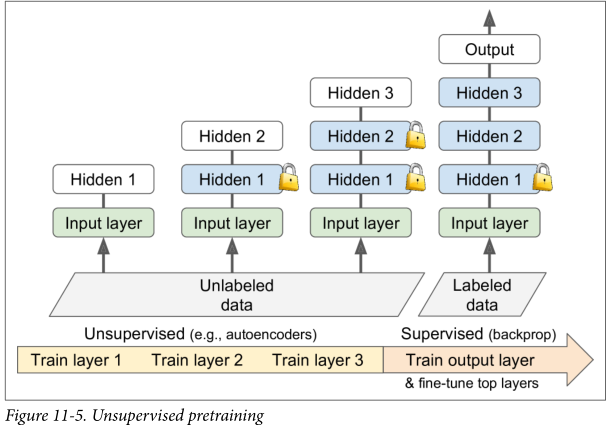

## 2.8 Pretraining on an Auxiliary Task

**最后一个选择是在辅助任务上训练第一个神经网络，在这个辅助任务上，你拥有可以轻松获取或生成标记的训练数据，然后重复使用该网络的较低层来完成你的实际任务**。第一个神经网络的下层将学习可能由第二个神经网络重用的特征检测器。

例如，如果要构建一个识别面部的系统，你可能只有一些每个人的照片——显然不足以训练一个好的分类器。收集每个人的数百张照片是不切实际的。但是，
* 你可以在互联网上收集大量随机人物的照片，并训练第一个神经网络，以检测两个不同的图片是否具有相同的人物。

这样的网络将学习一个良好的特征检测器用于面部识别，因此重用其较低层将允许你使用很少的训练数据训练良好的面部分类器。

收集未标记的训练示例通常相当便宜，但是标记它们相当昂贵。在这种情况下，**一种常见的技术是**

* **将所有训练样例标记为“好”**，
* 然后**通过破坏好的训练实例来生成许多新的训练实例，并将这些已损坏的实例标记为“不好”**。

* 然后，你可以**训练第一个神经网络将实例分类为好或不好**。

例如，你可以下载数百万个句子，将其标记为“好”，然后随机改变每个句子中的一个单词，并将得到的句子标记为“不好”。
如果一个神经网络可以告诉“狗睡觉”是一个好句子，但“他们的狗”是坏的，它可能对语言有很多了解。重用其较低层可能有助于许多语言处理任务。

**另一种方法是**

* 训练第一个网络输出每个训练实例的分数，
* 并使用成本函数确保一个好实例的得分比一个坏实例的得分大至少一些余量（some margin）。

这称为**最大边际（间隔）学习**。

# 3. Faster Optimizers

训练一个非常大的深度神经网络可能会非常缓慢。到目前为止，我们已经看到了**四种加速训练（并达到更好的解决方案）的方法**：
* 对连接权重应用良好的初始化策略，
* 使用良好的激活函数，
* 使用批量标准化，
* 以及重用预训练网络的部分。

**另一个巨大的速度提升来自使用比常规Gradient Descent优化器更快的优化器**。在本节中，我们将介绍最受欢迎的：
* 动量优化 - Momentum optimization，
* Nesterov Accelerated Gradient，
* AdaGrad，
* RMSProp，
* 以及最后的Adam优化。



**Spoiler alert:** **本节的结论是你应该几乎总是使用Adam优化**，所以，如果你不关心它是如何工作的，只需用**AdamOptimizer**替换你的**GradientDescentOptimizer**，然后跳到下一部分！

只需进行这一小改动，训练通常会快几倍。但是，Adam优化确实有三个可以调整的超参数（加上学习率）;默认值通常可以正常工作，但如果你需要调整它们，知道它们的作用可能会有所帮助。**Adam优化结合了其他优化算法的几个想法，因此首先查看这些算法很有用**。

## 3.1 Momentum optimization

**动量优化**

想象一下保龄球在光滑的表面上滚下缓缓的斜坡：

它会慢慢开始，但它会迅速加速，直到最终达到最终速度（如果有一些摩擦或空气阻力）。这是由Boris Polyak于1964年提出的**Momentum优化**背后的非常简单的想法。相比之下，常规的梯度下降只需沿着斜坡向下进行小规模的步骤，因此到达底部需要更多的时间。

回想一下，梯度下降仅通过直接减去成本函数  $J(θ)$ 关于权重 $(∇θJ(θ))$ 的梯度乘以学习速率 $η$ 来简单地更新权重 $θ$。等式为：$θ←θ - η∇θJ(θ)$。它并不关心早期的梯度是什么。如果局部梯度很小，则进展非常缓慢。

动量优化非常关注以前的梯度：在每次迭代中，它**将局部梯度添加到动量矢量 $m$（乘以学习速率$η$）**，并通过简单地减去该动量来更新权重向量（见公式11-4）。换句话说，**梯度用作加速度，而不是速度**。

为了模拟某种摩擦机制并防止动量增长过大，该算法引入了一个新的**超参数β**，简称为**动量**，必须**设置在0（高摩擦）和1（无摩擦）之间**。**典型的动量值为0.9**。
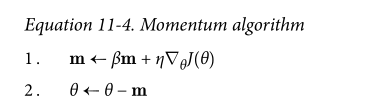

如果梯度保持不变，你可以轻松验证最终速度（即，权重更新的最大大小）等于该梯度乘以学习率$η$乘以$\frac{1}{1 - β}$。例如，如果$β= 0.9$，然后**最终速度等于梯度乘以学习速率的10倍，因此动量优化最终比Gradient Descent快10倍**！这使得动量优化能够比梯度下降更快地从高原逃脱。

特别是，我们在第4章中看到，**当输入具有非常不同的尺度时**，成本函数看起来就像一个细长的碗（见图4-7）。**梯度下降**速度非常快，但是需要很长时间才能进入山谷。相比之下，**动量优化**动量优化将越来越快地滚动到谷底，直到达到底部（最佳）。

在不使用**批量标准化**的深度神经网络中，上层通常最终会得到具有非常不同尺度的输入，因此使用Momentum优化可以提供很多帮助。它也可以帮助超越局部最优。

**由于动量，优化器可能会超出一点，然后回来，再次超调，并且在稳定到最小值之前多次振荡。这是在系统中产生一点摩擦力的原因之一：它消除了这些振荡，从而加速了收敛**。

在TensorFlow中实现动量优化是一个明智的选择：**只需用MomentumOptimizer替换GradientDescentOptimizer**，然后躺下来获利！

In [79]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

Momentum优化的一个**缺点是它增加了另一个需要调整的超参数**。 然而，**0.9的动量值通常在实践中运作良好，并且几乎总是比梯度下降更快**。

## 3.2 Nesterov Accelerated Gradient

**Nesterov加速梯度**
Momentum优化的一个小变种，由Yurii Nesterov于1983年提出，几乎总是比vanilla 动量优化更快。Nesterov 动量优化或Nesterov Accelerated Gradient（NAG）的思想是**测量成本函数的梯度，而不是在局部位置，而是在动量方向略微向前（见公式11-5）**。**与 vanilla 动量优化的唯一区别是梯度是在$θ+βm$而不是$θ$处测量的**。
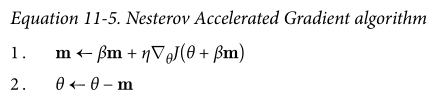

这个小调整是有效的，因为通常动量矢量将指向正确的方向（即朝向最佳方向），所以使用在该方向上稍微测量一点的梯度而不是在原始位置使用梯度会稍微准确一些，如图11-6所示（其中$∇_1$表示在此处测量的成本函数的梯度）起点$θ$，$∇_2$ 表示位于 $θ+βm$ 点处的梯度。

如你所见，
* Nesterov更新最终略微接近最佳状态。一段时间后，这些小改进加起来，NAG最终比常规Momentum优化快得多。
* 此外，请注意，当动量将权重推过一个山谷时，$∇_1$继续推进越过山谷，而$∇_2$ 则推回山谷的底部。这有助于减少振荡，从而更快地收敛。

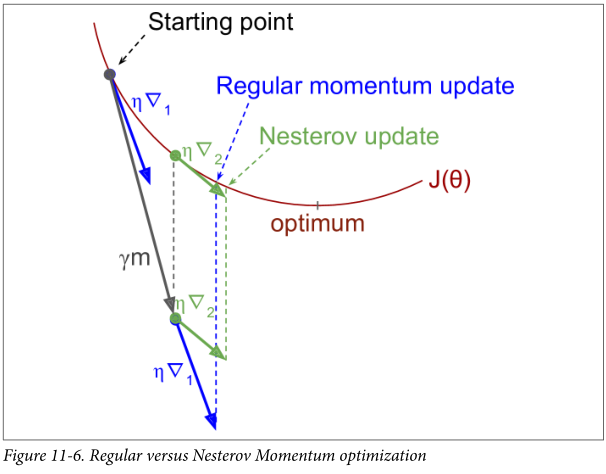

NAG 与常规动量优化相比，几乎总能加快训练速度。要使用它，

**只需在创建 MomentumOptimizer 时设置 use_nesterov = True**

In [80]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## 3.3 AdaGrad

再次考虑细长的碗问题：

梯度下降开始于快速下降到最陡的斜坡，然后缓慢下降到山谷的底部。如果算法能够及早发现并纠正其方向以指向全局最优点，那将是很好的。

**AdaGrad算法**通过沿最陡的尺寸缩小梯度向量来实现这一点（见公式11-6）：

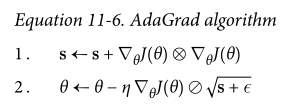

**第一步将梯度的平方累积到向量 $s$ 中**（⊗符号表示元素乘法）。该矢量化形式相当于对矢量 $s$ 的每个元素 $s_i$ 计算$s_i←s_i +(∂/∂θ_iJ(θ))^2$;换句话说，每个 $s_i$ 累加关于参数 $θ_i$ 的代价函数的偏导数的平方。如果成本函数沿着第 $i$ 维度陡峭，那么 $s_i$ 将在每次迭代时变得越来越大。


**第二步几乎与Gradient Descent相同，但有一个很大的区别**：梯度向量按比例缩小\sqrt[2]{s + ε}（⊘符号表示逐元素除法，$ε$是平滑项，以避免除以零，通常设置为$10^{ -10}$）。该矢量化形式相当于计算所有参数$θ_i$（同时）的
$θ_i \leftarrow θ_i-η∂/∂θ_iJ(θ)/ \sqrt[2]{s_i + ε} $。


简而言之，这种算法会降低学习率，**but it does so faster for steep dimensions than for dimensions with gentler slopes.**。这被称为**自适应学习率**。它有助于 **a.**将结果更新更直接地指向全局最优（见图11-7）。**b.** 另一个好处是它需要更少的学习速率超参数$η$的调整。

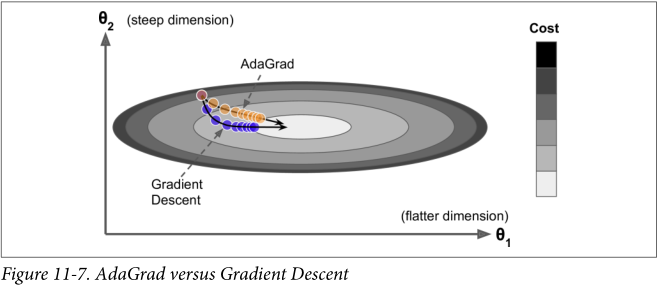

对于简单的二次问题，AdaGrad经常表现良好。但不幸的是，**它在训练神经网络时经常停止得太早。学习速率大大缩小，以至于算法在达到全局最优之前最终完全停止**。因此，**尽管TensorFlow具有AdagradOptimizer，但你不应该使用它来训练深度神经网络**（尽管可能对诸如线性回归之类的简单任务有效）。

In [81]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## 3.4 RMSProp

尽管AdaGrad的速度有点过快，但最终还是没有收敛到全局最优，**RMSProp算法**仅通过累积来自最近迭代的梯度（与自训练开始以来的所有梯度相反）来修正这一缺点。它**通过在第一步中使用指数衰减来实现**（见公式11-7）。

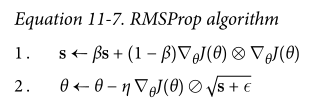

**衰减率$β$通常设定为0.9**。 是的，它又是一个新的超参数，但是这个默认值通常效果很好，所以你可能根本不需要调整它。

正如你所料，TensorFlow有一个**RMSPropOptimizer类**：

In [82]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

**除了非常简单的问题，这个优化器几乎总是比AdaGrad好得多。** 它通常**也比Momentum优化和Nesterov Accelerated Gradients表现更好**。实际上，在Adam优化出现之前，它是许多研究人员首选的优化算法。

## 3.5 Adam Optimization

**Adam，代表自适应矩估计，结合Momentum优化和RMSProp的想法**：
* 就像动量优化一样，它跟踪过去梯度的指数衰减平均值，
* 就像RMSProp一样，它跟踪过去平方梯度的指数衰减平均值（见公式11-8）。

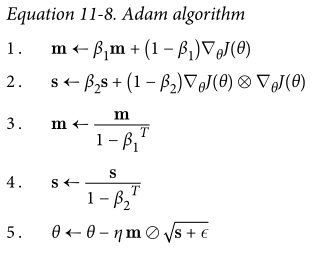

* $T$ 表示迭代次数（从1开始）。

如果你只看第1步，第2步和第5步，你会发现Adam与动量优化和RMSProp这两者非常相似。**唯一的区别是步骤 1 计算指数衰减的平均值而不是指数衰减的和，但这些实际上是等效的，除了常数因子**（衰减平均值只是衰减总和的$1 - β_1$倍）。

步骤3和4在某种程度上是技术细节：由于 $m$ 和 $s$ 初始化为0，因此在训练开始时它们将偏向0，因此这两个步骤将有助于在训练开始时提升 $m$ 和 $s$ 。

* 动量衰减超参数 $β_1$ 通常初始化为0.9，
* 而缩放衰减超参数 $β2$ 通常初始化为0.999。 
* 平滑项$ε$通常初始化为一个很小的数字，如$10^{-8}$。

这些是TensorFlow的AdamOptimizer类的默认值，因此你可以简单地使用：

In [83]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

实际上，由于Adam是一种自适应学习率算法（如AdaGrad和RMSProp），它需要较少调整学习速率超参数$η$。你通常可以使用默认值$η= 0.001$，这使得Adam比Gradient Descent更容易使用。

**到目前为止所讨论的所有优化技术仅依赖于一阶偏导数（雅可比行列式）**。优化文献包含基于二阶偏导数（Hessians）的惊人算法。不幸的是，这些算法很难应用于深度神经网络，因为每个输出有$n^2$个Hessians（其中n是参数个数），而不是每个输出只有 $n$ 雅可比。由于DNN通常具有数万个参数，因此**二阶优化算法通常甚至不适合内存**，即使它们确实存在，因为计算Hessians太慢了。

**Training Sparse Models**

刚刚提出的所有优化算法都产生了密集的模型，这意味着大多数参数都是非零的。如果你在运行时需要一个超快的模型，或者如果你需要它来占用更少的内存，你可能更喜欢产生**稀疏模型**。

* 实现这一目标的一个很简单的方法是像往常一样训练模型，然后摆脱微小的权重（将它们设置为0）。

* 另一个选择是在训练期间应用强 $ ℓ 1$ 正则化，因为它推动优化器将尽可能多的权重归零（如第4章中关于Lasso回归所讨论的那样）。


但是，在某些情况下，这些技术可能仍然不足。最后一个选择是应用**双平均 - Dual Averaging**，通常称为**跟随正规化领导者 - Follow The Regularized Leader （FTRL）**，这是Yurii Nesterov提出的技术。

当与 $ ℓ 1$正则化一起使用时，这种技术通常会导致非常稀疏的模型。 TensorFlow在**FTRLOptimizer类**中实现了一个名为**FTRL-Proximal**的FTRL变体。

## 3.6 Learning Rate Scheduling

**学习率调度**

找到一个好的学习率可能会很棘手。 
* 如果你**设置得太高**，训练可能实际上有所不同（正如我们在第4章中讨论的那样）。

* 如果你将它**设置得太低**，训练最终会收敛到最佳状态，但这需要很长时间。

* 如果你把它**设置得有点太高**，它一开始会很快进展，但最终会在最佳状态下跳舞，永远不会安定下来（除非你使用自适应学习速率优化算法，如AdaGrad，RMSProp或Adam，但是 即使这样，也许需要时间来解决）。

* 如果计算预算有限，则可能必须在正确收敛之前中断训练，从而产生次优解决方案（参见图11-8）。
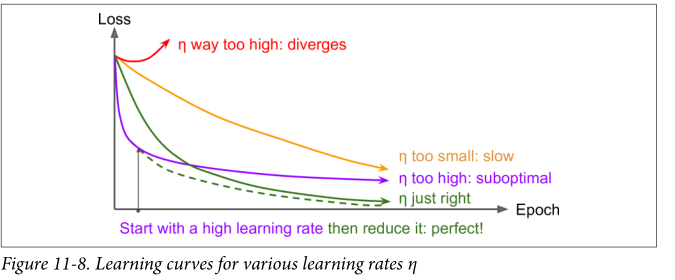

你可能会通过使用各种学习率并比较学习曲线，在几个时期内多次训练你的网络找到相当不错的学习率。理想的学习速度将快速学习并汇聚到良好的解决方案。

但是，你可以比恒定的学习率做的更好：**如果你从高学习率开始，然后一旦它停止快速进展就减少它**，你可以比最佳的恒定学习速率更快地达到一个好的解决方案。**在训练期间，有许多不同的策略可以降低学习率。这些策略称为学习计划** - learning schedules （我们在第4章中简要介绍了这个概念），其中最常见的是：

**Predetermined piecewise constant learning rate - 预定的分段不变学习率**

   * 例如，首先将学习率设置为$η_0= 0.1$，然后在50个epochs 之后将学习率设置为$η_1= 0.001$。虽然这种解决方案可 以很    好地工作，但通常需要摆弄很久以找出正确的学习率以及何时使用它们。

**Performance scheduling - 性能调度**

  * 每N步测量一次验证错误（就像早期停止一样），并在错误停止时将学习速率降低$λ$倍。

**Exponential scheduling - 指数调度**

  * 将学习率设置为迭代次数 $t$ 的函数：$η(t)=η_0 10^{-t/r}$。这很好用，但需要调整$η_0$ 和 $r$ 。学习率每 $r$ 步将下降10倍。

**Power scheduling - 电力调度**

  * 将学习率设置为$η(t）=η_0 (1 + t/r)^{-c}$。超参数 $c$ 通常设置为 1。这类似于指数调度，但学习速度下降得慢得多。

Andrew Senior等人2013年撰写的论文,**比较了使用动量优化训练深度神经网络进行语音识别时一些最流行的学习调度的表现**。作者得出结论，**在这种设置下，性能调度和指数调度都表现良好，但它们支持指数调度，因为它实现起来更简单，易于调优，并且可以更快地收敛到最优解**。 

使用TensorFlow实现学习调度非常简单：

```python
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                           decay_steps, decay_rate)

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
training_op = optimizer.minimize(loss, global_step=global_step)
```

设置超参数值后，我们
* 创建一个**nontrainable variable :global_step**（初始化为0）来跟踪当前的训练迭代次数。
* 然后我们使用TensorFlow的**exponential_decay（）函数**定义指数衰减学习率（$η_0= 0.1和 r = 10,000$）。 
* 接下来，我们**使用这种衰减学习率创建一个优化器**（在本例中为MomentumOptimizer）。

* 最后，我们通过调用优化器的**minimize（）方法**来创建训练操作; 因为我们传递了global_step变量，所以它会负责增加它。 
大功告成啦！

**由于 AdaGrad，RMSProp 和 Adam 优化 在训练期间会自动减少学习，没有必要增加额外的学习调度。对于其他优化算法，使用指数衰减或性能调度可以大大加快收敛速度**。

In [84]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [85]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [86]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [87]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.963
1 Validation accuracy: 0.9712
2 Validation accuracy: 0.9758
3 Validation accuracy: 0.9802
4 Validation accuracy: 0.9814


# 4. Avoiding Overfitting Through Regularization

*With four parameters I can fit an elephant and with five I can make him wiggle his trunk.*

—John von Neumann, cited by Enrico Fermi in Nature 427


深度神经网络通常有数万个甚至数百万个参数。有这么多参数，网络具有令人难以置信的自由度，可以拟合各种复杂的数据集。 但是这种极大的灵活性也意味着它很容易过度拟合训练集。拥有数百万个参数，您可以拟合整个动物园。

在本节中，我们将**介绍一些最流行的神经网络正则化技术**，以及如何使用TensorFlow实现它们：
* 早期停止 - Early Stopping
* $ℓ 1$ 和 $ℓ 2$ 正则化，
* 丢失 - dropout
* 最大范数正则化 - max-norm regularization
* 数据增强 - data augmentation

## 4.1 Early Stopping

**为了避免过度拟合训练集，一个很好的解决方案是提前停止**（在第4章介绍）：当它在验证集上的性能开始下降时，just 中断训练。

使用TensorFlow**实现此功能的一种方法是定期（例如，每50步）在验证集上评估模型**，
* 如果它优于以前的“赢家”snapshot，则保存“赢家”snapshot。

* 计算自上次“赢家”快照保存以来的步数，并在此数量达到某个限制（例如，2,000步）时中断训练。

* 然后恢复最后一个“赢家”snapshot。

**虽然早期停止在实践中非常有效，但是通过将其与其他正则化技术相结合，你通常可以从网络中获得更高的性能**。

## 4.2  $\ell_1$ and $\ell_2$ regularization

就像你在第4章中对简单线性模型所做的那样，你可以使用 $ℓ1$ 和 $ℓ2$ 正则化来约束神经网络的连接权重（但通常不是差）。

使用TensorFlow执行此操作的一种方法是**只需在你的成本函数中添加适当的正则化项**。例如，假设你只有一个带有权重weight1的隐藏层和一个权重为weight2的输出层，那么你可以像这样应用 $ℓ1$ 正则化：

```python
[...] # construct the neural network
base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
reg_losses = tf.reduce_sum(tf.abs(weights1)) + tf.reduce_sum(tf.abs(weights2))
loss = tf.add(base_loss, scale * reg_losses, name="loss")
```

然而，如果有很多层，这种方法不是很方便。幸运的是，TensorFlow提供了更好的选择。许多创建变量的函数（例如`get_variable（）`或`fully_connected（）`）接受每个创建变量的`*_regularizer参数` （例如，`weights_regularizer`）。

你可以传递任何以权重为参数的函数，并**返回相应的正则化损失**。`l1_regularizer（）`，`l2_regularizer（）`和`l1_l2_regularizer（）`函数返回这样的函数。 以下代码将所有这些放在一起：

```python
with arg_scope(
[fully_connected],
    weights_regularizer=tf.contrib.layers.l1_regularizer(scale=0.01)):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(n_hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
    
```

此代码
* 创建一个具有**两个隐藏层和一个输出层的神经网络**，
* 并且它还在图中创建节点以计算对应于每个层权重的 $ ℓ 1 $ 正则化损失。

* TensorFlow会自动将这些节点添加到包含所有正则化损失的特殊集合中。

你只需要将这些正则化损失添加到你的整体损失中，如下所示：

```python
reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
loss = tf.add(base_loss, scale * reg_losses, name="loss")
```

**不要忘记将正则化损失添加到你的整体损失中，否则它们将被忽略**

让我们手动实现$\ell_1$ 正则化。 

**首先**，我们像往常一样创建模型（为简单起见，这次只有一个隐藏层）：


In [88]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

**接下来**，我们处理层权重，计算总损失，它等于通常的交叉熵损失和$\ell_1$ 损失的总和（即权重的绝对值）： 

In [89]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

剩下的就像往常一样了：

In [90]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8282
1 Validation accuracy: 0.8642
2 Validation accuracy: 0.8822
3 Validation accuracy: 0.8898
4 Validation accuracy: 0.8946
5 Validation accuracy: 0.898
6 Validation accuracy: 0.9022
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9054
9 Validation accuracy: 0.9072
10 Validation accuracy: 0.9076
11 Validation accuracy: 0.9098
12 Validation accuracy: 0.9088
13 Validation accuracy: 0.9088
14 Validation accuracy: 0.9104
15 Validation accuracy: 0.909
16 Validation accuracy: 0.9086
17 Validation accuracy: 0.908
18 Validation accuracy: 0.9082
19 Validation accuracy: 0.9062


或者，**我们可以将正则化函数传递给f.layers.dense（）函数**，**该函数将使用它来创建计算正则化损失的运算，并将这些运算添加到正则化损失的集合中**。 

**开头与上面相同**：

In [92]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

**接下来**，我们将**使用Python的`partial()`函数来避免一遍又一遍地重复相同的参数。 请注意，我们设置了`kernel_regularizer`参数**：


In [93]:
scale = 0.001

In [94]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Instructions for updating:
Use the retry module or similar alternatives.


**接下来**，我们**必须将正规化损失添加到基本损失中**：

In [95]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    # 必须将正规化损失添加到基本损失中
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

其余的和往常一样：

In [96]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [97]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8126
1 Validation accuracy: 0.8702
2 Validation accuracy: 0.8884
3 Validation accuracy: 0.8982
4 Validation accuracy: 0.902
5 Validation accuracy: 0.9074
6 Validation accuracy: 0.9088
7 Validation accuracy: 0.9118
8 Validation accuracy: 0.9126
9 Validation accuracy: 0.9148
10 Validation accuracy: 0.916
11 Validation accuracy: 0.9162
12 Validation accuracy: 0.9158
13 Validation accuracy: 0.917
14 Validation accuracy: 0.9174
15 Validation accuracy: 0.9174
16 Validation accuracy: 0.9172
17 Validation accuracy: 0.9186
18 Validation accuracy: 0.9186
19 Validation accuracy: 0.9182


## 4.3 Dropout

最流行的深度神经网络正则化技术可以说是**dropout**。它由G. E. Hinton于2012年提出，并在Nitish Srivastava等人的论文中进一步详述，事实证明它非常成功：即使是最先进的神经网络，只需添加dropout，就可以提高1-2％的准确度。这可能听起来不是很多，但是**当模型已经具有95％的准确度时，获得2％的准确度提升意味着将错误率降低近40％（从5％误差变为大约3％）**。

这是一个相当简单的算法：
* 在每个训练步骤中，每个神经元（包括输入神经元但不包括输出神经元）都有一个暂时“退出”的概率 **p**，这意味着在此训练步骤中它将被完全忽略，但在下一步中它可能是活动的（见图11-9） 。

* 超参数 **p** 称为**丢失率 - dropout rate**，通常设置为50％。训练后，神经元不再被丢弃。

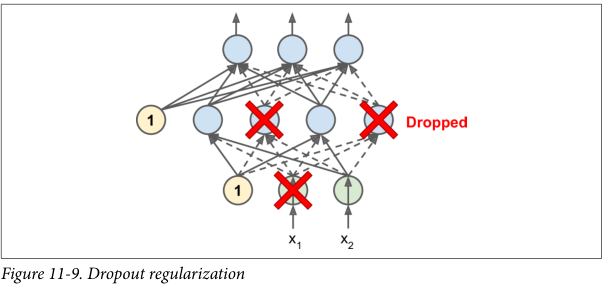

起初这个相当野蛮的技术起作用是非常令人惊讶的。如果员工被告知每天早上扔硬币来决定是否去上班，公司会表现得更好吗？嗯，谁知道呢;也许它会！
* 该公司显然会被迫调整其组织;它不能依赖任何一个人来填写咖啡机或执行任何其他关键任务，因此这种专业知识必须分散在几个人身上。
* 员工必须学会与他们的许多同事合作，而不仅仅是少数几个。该公司将变得更有弹性。

* 如果一个人退出，那就没有什么区别了。**目前还不清楚这个想法是否真的适用于公司，但它肯定适用于神经网络**（😄）。受dropout训练的神经元不能与其邻近的神经元共同适应;它们必须尽可能地有用。

* 他们也不能过分依赖几个输入神经元;他们必须注意每个输入神经元。他们最终对输入的微小变化不太敏感。最终，你将获得更强大的网络，从而更好地进行推广。

另一种了解 dropout 能力的方法是**要意识到在每个训练步骤中都会产生一个独特的神经网络**。由于每个神经元可以存在或不存在，因此总共有 $2^N$ 个可能的网络（其中 $N$ 是可丢弃神经元的总数）。这是一个巨大的数字，几乎不可能对同一个神经网络进行两次采样。一旦你运行了10,000个训练步骤，你基本上训练了10,000个不同的神经网络（每个只有一个训练实例）。
这些神经网络显然不是独立的，因为它们共享许多权重，但它们都是不同的。得到的神经网络可以看作是所有这些较小神经网络的平均集合。


**有一个小而重要的技术细节**。假设 p = 50，在这种情况下，

* 在测试期间，神经元将连接到训练期间（平均）两倍的输入神经元。

* 为了弥补这一事实，我们需要在训练后将每个神经元的输入连接权重乘以0.5。如果我们不这样做，每个神经元的总输入信号将大约是网络训练的两倍，并且不太可能表现良好。

更一般地说，**我们需要将每个输入连接权重乘以训练后的保持概率 $（1-p）$** 。或者，我们可以将每个神经元的输出除以训练期间的保持概率（这些替代方案不完全等效，但它们同样有效）。


要使用TensorFlow实现dropout，你可以简单地将**dropout（）函数**应用于输入层和每个隐藏层的输出。**在训练期间，此函数随机丢弃一些项（将它们设置为0）并将剩余项目除以保持概率**。训练结束后，此函数完全没有任何作用。

以下代码将**丢失正则化 - dropout regularization**应用于我们的三层神经网络：

```python
from tensorflow.contrib.layers import dropout

[...]
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)


hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,name="hidden1")
hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)

hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,name="hidden2")
hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)

logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")
```

注意：本书使用 `tf.contrib.layers.dropout()`而不是 `tf.layers.dropout()` .  现在最好使用`tf.layers.dropout()`, 因为contrib模块中的任何内容都可能更改或删除，恕不另行通知。  `tf.layers.dropout()` 函数几乎与`tf.contrib.layers.dropout()` 函数相同，只是有一些细微差别。 最重要的是：

* 你必须指定the dropout rate (`rate`)而不是 keep probability (`keep_prob`), 其中 `rate` 等于 `1 - keep_prob`,
*  `is_training`参数重命名为 `training`.

In [98]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [99]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [100]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [101]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9602
1 Validation accuracy: 0.9712
2 Validation accuracy: 0.9712
3 Validation accuracy: 0.975
4 Validation accuracy: 0.976
5 Validation accuracy: 0.9782
6 Validation accuracy: 0.981
7 Validation accuracy: 0.9808
8 Validation accuracy: 0.982
9 Validation accuracy: 0.9816
10 Validation accuracy: 0.9824
11 Validation accuracy: 0.9836
12 Validation accuracy: 0.9798
13 Validation accuracy: 0.9832
14 Validation accuracy: 0.982
15 Validation accuracy: 0.9834
16 Validation accuracy: 0.9832
17 Validation accuracy: 0.9842
18 Validation accuracy: 0.9832
19 Validation accuracy: 0.984


* 如果你发现模型过度拟合，你可以增加dropout rate（即减少keep_prob超参数）。
* 相反，如果模型欠拟合训练集，则应尝试降低dropout rate（即增加keep_prob）。它还可以帮助提高大型网络层的dropout rate，并减少小型网络层的dropout rate。

Dropout确实会显着减慢收敛速度，但是如果调整得当，它通常会产生更好的模型。因此，通常值得花费额外的时间和精力。

**Dropconnect**是dropout 的变体，其中各个连接被随机丢弃而不是整个神经元。 通常，dropout 表现更好。

## 4.4 Max norm

另一种在神经网络中非常流行的正则化技术被称为**最大范数正则化**：

对于每个神经元，它约束输入连接的权重 $w$，使得$∥w∥_2 ≤ r$，其中 $r$ 是最大范数超参数，而$∥·∥_2$是 $ℓ2$ 范数。

我们通常通过在每个训练步骤之后计算$∥w∥_2$, 并在需要时剪切 $w$（$w \leftarrow w \frac {r}{∥w∥_2}$）来实现此约束

减小 $r$ 会增加正则化的数量并有助于减少过拟合。Maxnorm正则化还可以帮助缓解梯度消失/爆炸问题（如果你不使用批量标准化）。



让我们回到MNIST的简单神经网络，只有2个隐藏层：

In [102]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

**接下来**，
* 让我们对第一个隐藏层的权重进行处理，并创建一个使用 `clip_by_norm()` 函数计算剪切权重的操作。 
* 然后我们创建一个赋值操作，将剪切的权重分配给权重变量：

In [103]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

我们也可以为第二个隐藏层执行此操作：

In [104]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

让我们添加一个 initializer 和 a saver:

In [105]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

现在我们可以训练模型了。
* 它与往常一样，除了在运行 `training_op`之后，
* 我们运行 `clip_weights` 和`clip_weights2` 操作：

In [106]:
n_epochs = 20
batch_size = 50

In [107]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Validation accuracy: 0.9578
1 Validation accuracy: 0.9696
2 Validation accuracy: 0.97
3 Validation accuracy: 0.9786
4 Validation accuracy: 0.978
5 Validation accuracy: 0.9792
6 Validation accuracy: 0.9822
7 Validation accuracy: 0.9814
8 Validation accuracy: 0.9796
9 Validation accuracy: 0.9792
10 Validation accuracy: 0.9814
11 Validation accuracy: 0.9826
12 Validation accuracy: 0.9812
13 Validation accuracy: 0.9838
14 Validation accuracy: 0.9818
15 Validation accuracy: 0.9824
16 Validation accuracy: 0.9824
17 Validation accuracy: 0.982
18 Validation accuracy: 0.983
19 Validation accuracy: 0.9828


上面的实现是直截了当的，它工作正常，但它有点凌乱。**更好的方法是定义`max_norm_regularizer()`函数**，并像使用早期的l1_reg ularizer（）函数一样使用它：：

In [108]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

然后你可以调用这个函数来获得一个最大范数正则化器（具有你想要的阈值）。

创建隐藏层时，可以将此正则化程序传递给`kernel_regularizer`参数：

In [109]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

**max_norm_regularizer()函数**返回 一个**参数化的max_norm（）函数**，你可以像使用任何其他正则化器一样使用它：

In [110]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [111]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

训练与往常一样，**除非你必须在每次训练操作后执行权重裁剪操作**：

In [112]:
n_epochs = 20
batch_size = 50

注意，max-norm regularization 不需要添加正则化损失项到你的整体损失函数，所以**max_norm（）**函数返回None。但是你仍然需要在每个训练步骤之后运行**clip_weights操作**，因此你需要能够处理它。**这就是max_norm（）函数将clip_weights节点添加到max-norm剪切操作集合的原因**。

你需要获取这些剪切操作并在每个训练步骤后运行它们：

In [113]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9588
1 Validation accuracy: 0.9718
2 Validation accuracy: 0.9708
3 Validation accuracy: 0.977
4 Validation accuracy: 0.9744
5 Validation accuracy: 0.98
6 Validation accuracy: 0.981
7 Validation accuracy: 0.9814
8 Validation accuracy: 0.981
9 Validation accuracy: 0.9808
10 Validation accuracy: 0.9828
11 Validation accuracy: 0.9838
12 Validation accuracy: 0.982
13 Validation accuracy: 0.9836
14 Validation accuracy: 0.9828
15 Validation accuracy: 0.9842
16 Validation accuracy: 0.9838
17 Validation accuracy: 0.9832
18 Validation accuracy: 0.9844
19 Validation accuracy: 0.9842


## 4.5 Data Augmentation

**最后一种正规化技术，数据扩增**，包括
* 从现有训练实例中生成新的训练实例，
* 人为地增加训练集的大小。

这将减少过拟合，使其成为一种正则化技术。

诀窍是生成真实的训练实例;理想情况下，人类不应该知道哪些实例是生成的，哪些实例不是。而且，简单地加入白噪声也无济于事;你应用的修改应该是可学习的（白噪声不是）。


例如，

* 如果你的模型是为了对蘑菇的图片进行分类，你可以以不同的量轻微**移动**，**旋转**和**调整训练集中每张图片的大小**，并将得到的图片添加到训练集中（参见图11-10）。这迫使模型更加容忍图片中蘑菇的位置，方向和大小。

* 如果你希望模型更能容忍光照条件，你可以类似地生成许多具有各种对比度的图像。

* 假设蘑菇是对称的，你也可以水平翻转图片。通过组合这些变换，你可以大大增加训练集的大小。

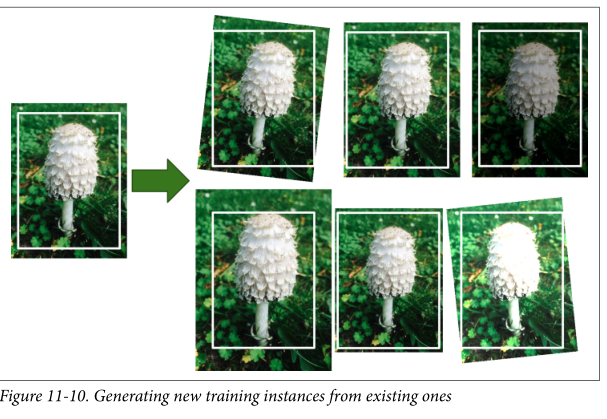

通常最好在训练期间动态生成训练实例而不是浪费存储空间和网络带宽。TensorFlow提供多种图像处理操作，如移调（移位），旋转，调整大小，翻转和裁剪，以及调整亮度，对比度，饱和度和色调（有关详细信息，请参阅API文档）。这样可以轻松实现图像数据集的数据增强。


另一种训练深度神经网络的强大技术是添加**跳过连接 - skip connections** （跳过连接是指将层的输入添加到更高层的输出）。
我们将在第13章讨论**深度剩余网络 - deep residual networks**时，探讨这个想法。

# 5. Practical Guidelines

在这一章当中，我们已经涵盖了大量的技术，你可能想知道你应该使用哪些技术。 表11-2中的配置在大多数情况下都能正常工作。
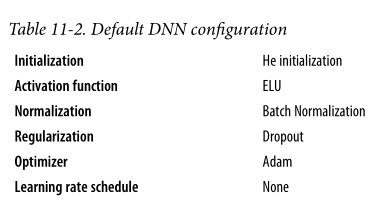

当然了，你应该尝试重用预训练神经网络的一部分，如果你能找到解决类似问题的神经网络。

可能需要调整此默认配置：

* **如果你找不到好的学习率**（收敛太慢，所以你提高了训练率，现在收敛速度很快，但网络的准确性不是最理想的），然后你可以尝试添加一个学习调度，如**指数衰减**。

* 如果你的训练集太小，则可以实现数据扩增。

* 如果你需要一个稀疏模型，你可以在混合中添加一些 $ℓ1$ 正则化（以及训练后可选择将微小的权重归零）。

* 如果你需要一个更稀疏的模型，你可以**尝试使用 FTR 和 $ℓ1$ 正则化而不是Adam优化**。

* 如果你需要在运行时使用快如闪电的模型，你可能希望删除批量标准化，并可能**用leaky ReLU替换ELU激活函数**。

* 拥有一个稀疏模型也会有所帮助。

根据这些准则，你现在已经准备好训练非常深的网了 - 好吧，如果你非常有耐心的话，那就万事俱备了！

如果你使用一台机器，你可能需要等待数天甚至数月才能完成训练。 **在下一章中，我们将讨论如何使用分布式TensorFlow在许多服务器和GPU上训练和运行模型**。